In [18]:
from shallowmind.src.model import ModelInterface
from shallowmind.src.data import DataInterface
from shallowmind.api.infer import prepare_inference
import pandas as pd
import torch
from tqdm import tqdm
import pickle
import numpy as np
import pytorch_lightning as pl
pl.seed_everything(42)
from einops import rearrange
import os
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from torch import nn
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
# seed everything to 42
pl.seed_everything(42)
np.random.seed(42)
torch.manual_seed(42)

class CustomSoftMax(nn.Module):
    def __init__(self, axis=-1, zero_features=[], value=0):
        super(CustomSoftMax, self).__init__()
        self.axis = axis
        self.value = value
        self.zero_features = zero_features
        self.softmax = nn.Softmax(dim=axis)

    def forward(self, x):
        # 计算 softmax
        x = self.softmax(x)
        
        # 将指定特征的输出置为 0
        if self.zero_features:
            # 根据 zero_features 中的索引，将对应的特征置零
            idx = torch.tensor(self.zero_features, device=x.device)
            x.index_fill_(dim=self.axis, index=idx, value=self.value)

        return x

def calculate_statistics(res):
    acc = accuracy_score(res['label'], res['pred'])
    recall = recall_score(res['label'], res['pred'], average='macro')
    precision = precision_score(res['label'], res['pred'], average='macro')
    f1 = f1_score(res['label'], res['pred'], average='macro')
    pr_auc = average_precision_score(res['label'], res['pred'])
    roc_auc = roc_auc_score(res['label'], res['pred'])
    return {'acc': acc, 'recall': recall, 'precision': precision, 'f1': f1, 'pr_auc': pr_auc, 'roc_auc': roc_auc}

def get_res(model, test_loader, icenter_need_to_replaced = [], replaced_way = None, method='0', ilayer=0, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), batch_size=256):
    all_atten = []
    embs = []
    all_data = []
    outputs = []
    
    # for ic in icenter_need_to_replaced:
    #     current_param = model.model.encoder.encoder.layers[ilayer].self_attn.rules_keys[:,ic]
    #     new_param = replaced_way(current_param, method)
    #     with torch.no_grad():
    #         model.model.encoder.encoder.layers[ilayer].self_attn.rules_keys[:,ic] = new_param
    model.model.encoder.encoder.layers[ilayer].self_attn.softmax = CustomSoftMax(axis=-1, zero_features=icenter_need_to_replaced)
    model.model.encoder.decoder.layers[ilayer].self_attn.softmax = CustomSoftMax(axis=-1, zero_features=icenter_need_to_replaced)
    model = model.to(device)
    model = model.eval()
    res = pd.DataFrame()

    # test_loader is a torch.utils.data.DataLoader, not update the batch_size
    test_loader = torch.utils.data.DataLoader(test_loader.dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    for batch_idx, d in enumerate(test_loader):
        torch.cuda.empty_cache()
        data = {'seq': d[0]['seq'].to(device)}
        label = d[1].to(device)
        with torch.no_grad():
            imgs = model.model.gen_data(data)
            output, attention = model.model.encoder.encoder.layers[ilayer].self_attn(imgs, imgs, imgs, return_atten=True)
            attention = torch.cat([attention[:attention.shape[0]//2, :], attention[attention.shape[0]//2:, :]], dim=1)
            output = torch.cat([output[:output.shape[0]//2, :], output[output.shape[0]//2:, :]], dim=1)
            all_atten.append(attention.cpu().numpy())
            all_data.append(imgs.cpu().numpy())
            outputs.append(output.cpu().numpy())
            latent = model.model.forward_encoder(imgs)
            latent = torch.cat([latent[:latent.shape[0]//2, :], latent[latent.shape[0]//2:, :]], dim=1)
            embs.append(latent.cpu().numpy())
            latent = model.model.cls(latent)
            pred = latent.squeeze(1)
            pred = torch.argmax(pred, dim=1)
            pred = pred.cpu().numpy()
            label = label.cpu().numpy()
            res = pd.concat([res, pd.DataFrame({'pred': pred, 'label': label})], axis=0)
            
    all_data = np.concatenate(all_data, axis=0)
    embs = np.concatenate(embs, axis=0)
    all_atten = np.concatenate(all_atten, axis=0)
    output = np.concatenate(outputs, axis=0)
    res = res.reset_index(drop=True)

    return {'res': res, 'embs': embs, 'all_data': all_data, 'all_atten': all_atten,'layer_output': output}

def replaced_way(centers, method='0'):
    if method == '0':
        return torch.zeros_like(centers, requires_grad=True)
    if method == 'shuffle':
        new_centers = centers.clone()
        # shuffle the centers
        new_centers = centers[torch.randperm(centers.shape[0])]
    if method == 'random':
        min_v = centers.min()
        max_v = centers.max()
        new_centers = torch.randn_like(centers, requires_grad=True)
        new_centers = new_centers * (max_v - min_v) + min_v
        new_centers = new_centers[torch.randperm(new_centers.shape[0])]

    if method == 'same':
        new_centers = centers.clone()
    return new_centers

def get_table_one(config, ckpt, device = 'cuda', ilayer = 0, batch_size = 100, method='random', center_one = [0], center_name = [0]):
    data_module, model = prepare_inference(config, ckpt)
    data_module.setup()
    test_loader = data_module.test_dataloader()
    data_table = test_loader.dataset.data_table
    output = get_res(model, test_loader, center_one, replaced_way, method=method, ilayer=ilayer, device = torch.device(device), batch_size = batch_size)
    stat = calculate_statistics(output['res'])
    stat['center_name'] = center_name

    return stat, output

def get_table_main(config, ckpt, device = 'cuda', ilayer = 0, batch_size = 100, method='random', centers = [[],], metrics = 'pr_auc'):
    res_stat = []
    outputs = []
    for center_one in tqdm(centers, total=len(centers)):
        torch.cuda.empty_cache()
        stat, output = get_table_one(config, ckpt, device = device, ilayer = ilayer, batch_size = batch_size, method=method, center_one = center_one, center_name = center_one)
        res_stat.append(stat)
        outputs.append(output)
    res_stat = pd.DataFrame(res_stat)
    res_stat = res_stat.sort_values(by=metrics, ascending=False)
    return res_stat, outputs

def convert(linear_layer,y):
    W = linear_layer.weight.data
    b = linear_layer.bias.data
    print("W",W.min(),W.max(),W.shape)
    print("b",b.min(),b.max(),b.shape)
    W_pinv = torch.pinverse(W)
    print("W_pinv",W_pinv.min(),W_pinv.max(),W_pinv.shape)
    # Adjust the bias shape for the operation
    b = b.unsqueeze(0)  # Make b the same shape as y for subtraction
    # Attempt to recover x using the pseudoinverse
    recovered_x = torch.matmul(W_pinv, (y - b).T).T  # Adjusted operation
    return recovered_x


Global seed set to 42
Global seed set to 42


In [19]:
ckpt = '/home/xiaowjia/data/Friends_fNIRS/work_dir_test/test-no-dropout-noproj-FTF-ds=PictureClass_d-d=1-nh=5-r=10-bs=256-ls=0.00015-label=hand-drs=42/ckpts/last.ckpt'
config = '/home/xiaowjia/data/Friends_fNIRS/work_dir_test/test-no-dropout-noproj-FTF-ds=PictureClass_d-d=1-nh=5-r=10-bs=256-ls=0.00015-label=hand-drs=42/Fuzzy_test.py'

# ckpt = '/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/Friends_fNIRS_Fuzzy/work_dir_rule/FTF-ds=PictureClass_d-d=1-nh=5-r=10-bs=128-ls=0.00015-label=hand-drs=42/ckpts/exp_name=FTF-ds=PictureClass_d-d=1-nh=5-r=10-bs=128-ls=0.00015-label=hand-drs=42-cfg=Fuzzy_norm-bs=128-seed=42-val_f1_score=0.7670.ckpt'
# config = '/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/Friends_fNIRS_Fuzzy/work_dir_rule/FTF-ds=PictureClass_d-d=1-nh=5-r=10-bs=128-ls=0.00015-label=hand-drs=42/Fuzzy_norm.py'

### Center

In [ ]:
# ckpt = '/home/xiaowjia/data/Friends_fNIRS/work_dir/FTF-ds=PictureClass_d-d=3-nh=5-r=10-bs=256-ls=0.0015-label=hand/ckpts/exp_name=FTF-ds=PictureClass_d-d=3-nh=5-r=10-bs=256-ls=0.0015-label=hand-cfg=FuzzyTramsformer_num_rules10_num_heads5_dataset_name=PictureClass_label=hand_base_lr=1.5e-3_depth=3_batch_size=256-bs=256-seed=42-val_f1_score=0.8364.ckpt'
# config = '/home/xiaowjia/data/Friends_fNIRS/work_dir/FTF-ds=PictureClass_d-d=3-nh=5-r=10-bs=256-ls=0.0015-label=hand/FuzzyTramsformer_num_rules10_num_heads5_dataset_name=PictureClass_label=hand_base_lr=1.5e-3_depth=3_batch_size=256.py'

# ckpt = '/home/xiaowjia/data/Friends_fNIRS/work_dir/FTF-ds=PictureClass_d-d=1-nh=8-r=10-bs=256-ls=0.015-label=hand/ckpts/exp_name=FTF-ds=PictureClass_d-d=1-nh=8-r=10-bs=256-ls=0.015-label=hand-cfg=FuzzyTramsformer_num_rules10_num_heads8_dataset_name=PictureClass_label=hand_base_lr=1.5e-2_depth=1_batch_size=256-bs=256-seed=42-val_f1_score=0.8210.ckpt'
# config = '/home/xiaowjia/data/Friends_fNIRS/work_dir/FTF-ds=PictureClass_d-d=1-nh=8-r=10-bs=256-ls=0.015-label=hand/FuzzyTramsformer_num_rules10_num_heads8_dataset_name=PictureClass_label=hand_base_lr=1.5e-2_depth=1_batch_size=256.py'

num_centers = 10
batch_size = 256
ilayer = 0

device = 'cuda'
method = 'shuffle'
metrics = 'pr_auc'

res_all = []
last_center = []
for istep in range(num_centers):
    res_stat, _ = get_table_main(config, ckpt, device = device, ilayer = ilayer, batch_size = batch_size, method=method, 
                                 centers = [last_center + [i] for i in range(num_centers) if i not in last_center], metrics = metrics)
    last_center = res_stat['center_name'].iloc[-1]
    res_all.append({'istep': istep, 'res_stat': res_stat, 'last_center': last_center, 'method': method})


In [ ]:
for i in range(num_centers):
    plt.scatter(i, res_all[i]['res_stat']['pr_auc'].iloc[-1])
    plt.text(i,  res_all[i]['res_stat']['pr_auc'].iloc[-1], str(res_all[i]['res_stat']['center_name'].iloc[-1]))

In [24]:
num_centers = 10
batch_size = 256
ilayer = 0

device = 'cuda'
method = 'shuffle'
metrics = 'pr_auc'

res_stat, output = get_table_main(config, ckpt, device = device, ilayer = ilayer, batch_size = batch_size, method=method, centers = [list(range(num_centers))], metrics = metrics)

res_stat1, output = get_table_main(config, ckpt, device = device, ilayer = ilayer, batch_size = batch_size, method=method, centers = [[]], metrics = metrics)

100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


In [25]:
res_stat

,acc,recall,precision,f1,pr_auc,roc_auc,center_name
0,0.751714,0.749046,0.752465,0.749682,0.702467,0.749046,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


In [26]:
res_stat1

,acc,recall,precision,f1,pr_auc,roc_auc,center_name
0,0.755387,0.751747,0.758057,0.752461,0.70325,0.751747,[]


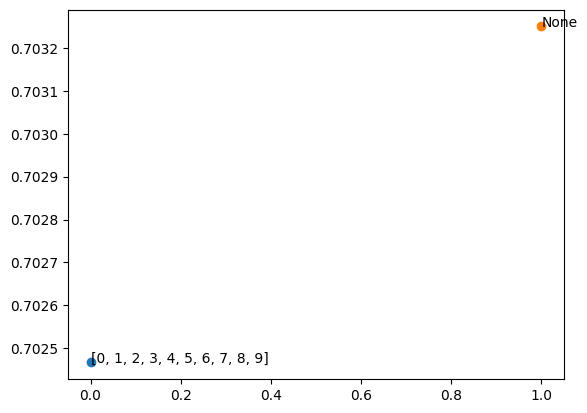

In [28]:
import matplotlib.pyplot as plt
# resort the results by pr_auc and plot this.
# write the center neumber near the point
res_stat = res_stat.sort_values(by='pr_auc', ascending=False)
for i in range(res_stat.shape[0]):
    plt.scatter(i, res_stat['pr_auc'].iloc[i])
    plt.text(i, res_stat['pr_auc'].iloc[i], str(res_stat['center_name'].iloc[i]))

# plot the pr_auc of the model without any rule
plt.scatter(res_stat1.shape[0], res_stat1['pr_auc'].iloc[0])
plt.text(res_stat1.shape[0], res_stat1['pr_auc'].iloc[0], 'None')
plt.show()

### UMAP

In [10]:
from shallowmind.src.model import ModelInterface
from shallowmind.src.data import DataInterface
from shallowmind.api.infer import prepare_inference
import pandas as pd
import torch
from tqdm import tqdm
import pickle
import numpy as np
import pytorch_lightning as pl
pl.seed_everything(42)
from einops import rearrange
import os
import numpy as np
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
# from tqdm import tqdm
def denormalize(x_scaled, min_val, max_val):
    # Scale from [-1, 1] to [0, 1]
    x_normalized = (x_scaled + 1) / 2
    # Denormalize to [min_val, max_val]
    x = x_normalized * (max_val - min_val) + min_val
    return x

def convert(linear_layer,y):
    W = linear_layer.weight.data
    b = linear_layer.bias.data
    W_pinv = torch.pinverse(W)
    # Adjust the bias shape for the operation
    b = b.unsqueeze(0)  # Make b the same shape as y for subtraction
    # Attempt to recover x using the pseudoinverse
    recovered_x = torch.matmul(W_pinv, (y - b).T).T  # Adjusted operation
    return recovered_x

def plot_umap(all_data,correct_ind, special_data, save_dir):
    # Assuming 'all_data' is your dataset and has the shape [17028, 2, 40, 33]
    # And 'special_data' is a subset of 'all_data' with a special characteristic

    # Flatten the data for UMAP
    subject_data=rearrange(all_data, 'b h c d -> b c (h d)')
    subject_data=rearrange(subject_data, 'b h d-> (b h) d')
    # subject_data=subject_data[correct_ind[0]]
    data_flattened=subject_data
    # data_flattened=rearrange(subject_data, 'c t -> (c t) w')
    # data_flattened = rearrange(all_data, 'b c h w -> (b c h) w')
    special_data_flattened = special_data
    if not os.path.exists(save_dir+'umap_data.pkl'):
        # Apply UMAP
        umap_reducer = UMAP(n_components=2,low_memory=False)  # Use 2 for 2D visualization
        data_umap = umap_reducer.fit_transform(data_flattened)
        special_data_umap = umap_reducer.transform(special_data_flattened)  # Transform special data
        # save
        with open(save_dir + 'umap_data.pkl', 'wb') as f:
            pickle.dump(data_umap, f)
        with open(save_dir + 'umap_special_data.pkl', 'wb') as f:
            pickle.dump(special_data_umap, f)
    else:
        with open(save_dir + 'umap_data.pkl', 'rb') as f:
            data_umap = pickle.load(f)
        with open(save_dir + 'umap_special_data.pkl', 'rb') as f:
            special_data_umap = pickle.load(f)

    # Visualize
    plt.scatter(data_umap[:, 0], data_umap[:, 1], s=1, label='All Data', alpha=0.3, c='blue')
    plt.scatter(special_data_umap[:, 0], special_data_umap[:, 1], s=10, marker='*', label='Special Data', alpha=0.7, c='red')
    plt.title('UMAP Visualization of the Data')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    figure_name = 'umap_norm.png'
    
    # Save the visualization
    plt.savefig(save_dir + figure_name)
    plt.show()

save_dir='./output/'
os.makedirs(save_dir, exist_ok=True)
ckpt = '/home/xiaowjia/data/Friends_fNIRS/work_dir_test/test-no-dropout-noproj-FTF-ds=PictureClass_d-d=1-nh=5-r=10-bs=256-ls=0.00015-label=hand-drs=42/ckpts/last.ckpt'
config = '/home/xiaowjia/data/Friends_fNIRS/work_dir_test/test-no-dropout-noproj-FTF-ds=PictureClass_d-d=1-nh=5-r=10-bs=256-ls=0.00015-label=hand-drs=42/Fuzzy_test.py'
data_module, model = prepare_inference(config, ckpt)
data_module.setup()

centers=model.model.encoder.encoder.layers[0].self_attn.rules_keys
centers=rearrange(centers, 'h r d -> r (h d)')
test_loader = data_module.test_dataloader()
data_table = test_loader.dataset.data_table
model = model.eval()

device = torch.device('cpu')
model = model.to(device)
val_loader = data_module.val_dataloader()
data_table = val_loader.dataset.data_table
res = pd.DataFrame(columns=['pred', 'label'])

embs = []
data_info = test_loader.dataset.data_index_table
all_data=[]
for batch_idx, d in tqdm(enumerate(test_loader), total=len(test_loader)):
    torch.cuda.empty_cache()
    data = {'seq': d[0]['seq'].to(device),}
    # all_data.append(data['seq'])
    label = d[1].to(device)
    with torch.no_grad():
        imgs = model.model.gen_data(data)
        # print(model.model.encoder.encoder.layers[0].self_attn)
        output,query= model.model.encoder.encoder.layers[0].self_attn(imgs,imgs,imgs,return_query=True)
        query = torch.cat([query[:query.shape[0]//2, :], query[query.shape[0]//2:, :]], dim=2)
        all_data.append(query)
        latent = model.model.forward_encoder(imgs)
        latent = torch.cat([latent[:latent.shape[0]//2, :], latent[latent.shape[0]//2:, :]], dim=1)
        embs.append(latent.cpu().numpy())
        latent = model.model.cls(latent)
        pred = latent.squeeze(1)
        pred = torch.argmax(pred, dim=1)
        pred = pred.cpu().numpy()
        label = label.cpu().numpy()
        res = pd.concat([res, pd.DataFrame({'pred': pred, 'label': label})], axis=0)

data_info = data_info.reset_index(drop=True)
res = res.reset_index(drop=True)
res = pd.concat([data_info, res], axis=1)
res["check"] = res["pred"] == res["label"]
correct_ind=res["check"].index[res["check"]==True].tolist()
embs = np.concatenate(embs, axis=0)
all_data = torch.cat(all_data, dim=0).cpu().numpy()

print("all_data",all_data.shape, 'centers', centers.shape)
min_val=model.model.encoder.encoder.layers[0].self_attn.norm.min_val
max_val=model.model.encoder.encoder.layers[0].self_attn.norm.max_val
scale=model.model.encoder.encoder.layers[0].self_attn.scale
# reverse all_data
de_data=denormalize(all_data, min_val, max_val)/scale
de_center=denormalize(centers, min_val, max_val)/scale
# plot_umap(de_data, correct_ind,de_center.detach().numpy(), save_dir)
subject_data = rearrange(de_data, 'b h c d -> b (h d) c')


Global seed set to 42
100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


all_data (8168, 5, 190, 8) centers torch.Size([10, 40])


In [26]:
# use Euclidean distance to find the nearest center D: (B, S, C), C: (R, C) d(D, C) -> (B, S, R)
import numpy as np
import einops
def euclidean_distance(D, C):
    """
    Computes the Euclidean distance between each sample in D and each reference point in C.
    
    Args:
    D (np.array): A numpy array of shape (B, S, C) where B is the number of batches, S is the number of samples per batch, and C is the number of features.
    C (np.array): A numpy array of shape (R, C) where R is the number of reference points and C is the number of features.

    Returns:
    np.array: A numpy array of shape (B, S, R) containing the Euclidean distances from each sample in D to each reference point in C.
    """
    D_expanded = np.expand_dims(D, axis=2)  # Shape: (B, S, 1, C)
    C_expanded = np.expand_dims(C, axis=0)  # Shape: (1, 1, R, C)

    # Compute squared differences, sum over feature dimension, and take square root
    distances = np.sqrt(np.sum((D_expanded - C_expanded) ** 2, axis=-1))
    return distances

distances = euclidean_distance(einops.rearrange(subject_data, 'b c s -> b s c'), de_center.detach().numpy())
l0_distance = distances[(res['label'] == 0) & (res['pred'] == res['label'])]
l1_distance = distances[(res['label'] == 1) & (res['pred'] == res['label'])]





(2717, 190, 10)
(190, 10)


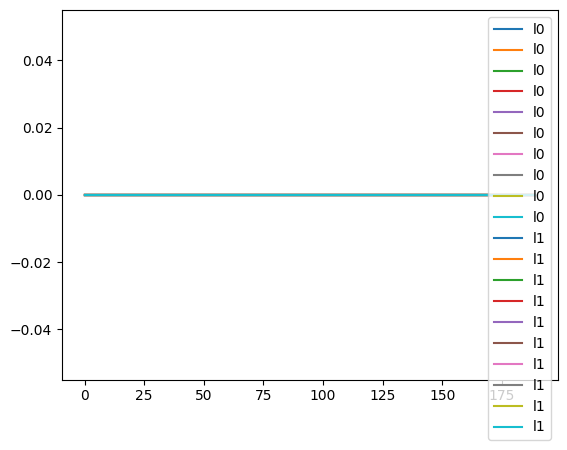

In [36]:
# small distance is better from small to large
l0_distance_idx = np.argsort(l0_distance, axis=-1)
l1_distance_idx = np.argsort(l1_distance, axis=-1)

print(l0_distance_idx.shape)

# calculate the percentage of the center(axis=2) at each position(axos=1) among all the correct samples(axis=0)
precentage_l0 = np.zeros_like(l0_distance_idx[0])
precentage_l1 = np.zeros_like(l1_distance_idx[0])
print(precentage_l0.shape)
for itime in range(l0_distance_idx.shape[1]):
    for irule in range(l0_distance_idx.shape[2]):
        precentage_l0_each = np.sum(l0_distance_idx[:, itime, irule] == irule)/l0_distance_idx.shape[0]
        precentage_l0[itime, irule] = precentage_l0_each
        precentage_l1_each = np.sum(l1_distance_idx[:, itime, irule] == irule)/l1_distance_idx.shape[0]
        precentage_l1[itime, irule] = precentage_l1_each

plt.plot(precentage_l0, label='l0')
plt.plot(precentage_l1, label='l1')
plt.legend()
plt.show()


